# Blog: Trying out the use of covariance matrices in Gaia DR2 distance estimations from parallax

Using a sample of quasars in *Gaia* DR2, [Lindegren et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180409366L) find a positive covariance between parallax uncertainties, where they quantify the covariance as

$V_\varpi(\theta_{ij}) = <(\varpi_i - \overline{\varpi})(\varpi_j - \overline{\varpi})>$

where $\theta_{ij}$ is the angular separation between two parallaxes $i$ and $j$, and $\overline\varpi$ is the mean parallax of all the quasars in subsections of the sample $(0.057 \times 0.057 \rm deg^2$, in their case).

For angles $<40^\circ$ they find that the large-scale systematics are reasonably well approximated by the fitted exponential

$V_\varpi(\theta_{ij}) = (285\mu \rm{as}^2) \times exp(-\theta/14^\circ)$

We will try and recreate the work by [Bailer-Jones et al. 2018](http://adsabs.harvard.edu/abs/2018AJ....156...58B) in order to find distances given the parallaxes and a reasonable prior as given by Bailer-Jones (2015), first without and then with taking covariances between parallax uncertainties into account. We will also be using some of the methodology from the [Zinn et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180502650Z) work.

**Important Note:** Do not confuse this with the covariance between the products of the astrometric solution, i.e. ra, dec, proper motions and parallax. I am here interested in the local covariance of uncertainties in parallax *alone*.

The model we'll be using is a Bayesian model in PyStan: we use the parallaxes and parallax uncertainties, along with a exponentially decaying space distance prior (Bailer-Jones et al. 2018) to estimate the 'true parallax', i.e. one over the distance in parsec.

An acyclic diagram for this can be seen below, where $\hat\varpi$ is the parallax, $\sigma_{\hat\varpi}$ is the uncertainties, $r_i$ is the inferred distance and $L_i$ is the value for the length scale of the distance prior given in the Bailer-Jones et al. 2018 work.

![Acyclic diagram for our model](blogmodel.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
from astropy.table import Table

Lets first read in the Kepler data set. Lets take the first 200 stars or so. Thanks [Megan Bedell](https://gaia-kepler.fun/)!

In [2]:
#Since they're sorted by KIC number, I'm going to shuffle so I select randomly
from sklearn.utils import shuffle
data = Table.read('../../data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
kdf = shuffle(data.to_pandas()).reset_index(drop=True)
kdf.rename(columns={'kepid':'KICID'},inplace=True)

Targets in our dataframe: 200


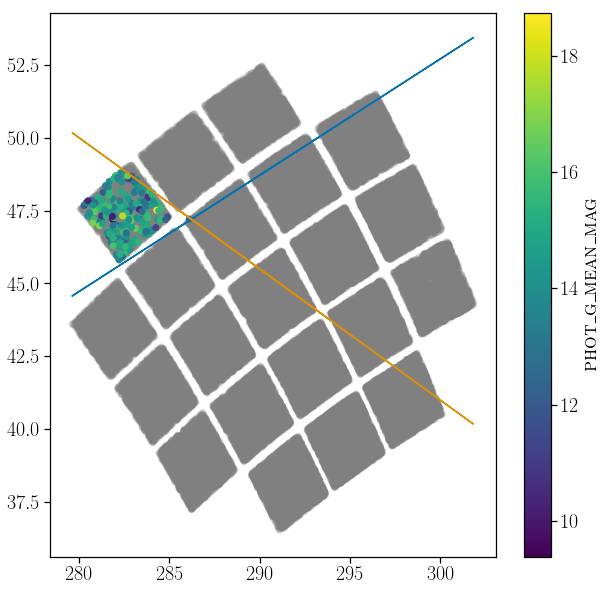

,designation,source_id,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,Gaia DR2 2107665010497737344,2.107665e+18,2015.5,283.332663,0.02089,47.799969,0.022562,0.771102,0.022375,34.462856,...,-0.072,DSEP,0.0,0.0,0.0,13.6,13.21,13.132,none,0.01652


In [3]:
#Lets select a single CCD (very roughly (and I really mean *very* roughly))
y1 = 0.399*kdf.ra - 67
y2 = -0.45*kdf.ra + 176
cdf = kdf[(kdf.dec > y1) & (kdf.dec < y2)].reset_index(drop=True)

#And then lets take the first 200 of those at random
df = cdf[:200]

print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(10,10))
a.plot(kdf.ra, y1)
a.plot(kdf.ra, y2)
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.phot_g_mean_mag, cmap='viridis')
f.colorbar(c, label=r"$\textsc{phot\_g\_mean\_mag}$")
plt.show()
df.head(1)

## First, lets do this not taking into account any covariances

Please note that I include the (hotly debated) parallax zero-point offset as used in the Bailer-Jones  et al. 2018 work, which I'm aiming to recreate here.

In [4]:
import pystan
overwrite=False
nocov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    vector[N] oo;
    vector[N] oo_err;
    real L[N];
}
parameters {
    vector<lower = 1.>[N] ri;                         //Can't have something being closer than 1 parsec!
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);
        oo_true[n] = (1000./ri[n] - 0.029);           //We're accounting for a parallax offset of 0.029 mu-as
    }

    oo ~ normal(oo_true, oo_err);
}
'''
import os
import pickle
model_path = 'nocov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = nocov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = nocov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [5]:
dat = {'N': len(df),
        'oo' : df.parallax.values,       #Observed parallax
        'oo_err' : df.parallax_error.values,   #Observed parallax error
        'L': df.r_length_prior.values}   #Length Scale

fit = sm.sampling(data=dat, iter=1000, chains=2)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now lets have a quick look at what the inferred distances look like, and how they compare to those presented in Bailer-Jones et al. 2018.

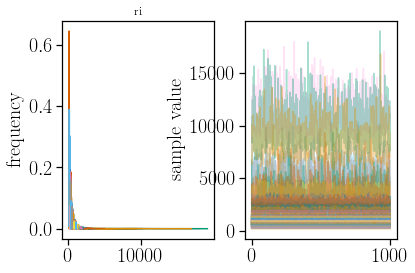

In [6]:
fit.plot()
plt.show()
# print(fit)

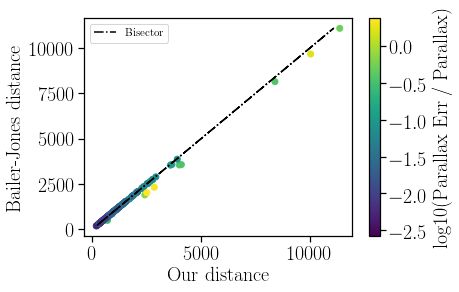

In [7]:
rinfd_nocov = np.median(fit['ri'], axis=0)

fig, ax = plt.subplots()
c = ax.scatter(rinfd_nocov, df.r_est.values, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis')
ax.plot(df.r_est, df.r_est, linestyle='-.', c='k', label='Bisector')
ax.legend()
fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('Our distance')
ax.set_ylabel('Bailer-Jones distance')
plt.show()

Not bad! Theres some scatter and it tails off for large fractional uncertainties, but thats expected given this quick and easy approach--- I'm also estimating our distances as the median of the distribution, **unlike** Bailer-Jones et al., who take the **mode of the distribution**. But we've got something that looks reasonable, at least!

## Now lets do the same again, but accounting for covariance!

The parallax uncertainties can covary as a function of angular separation, as quantified in Lindegren et al. 2018 to be:

$V_\varpi(\theta_{ij}) = (285\mu \rm{as}^2) \times exp(-\theta/14^\circ)$

Using this we can build up a covariance matrix for our targets. Formally, this would be as described in Zinn et al. 2018:

$\Sigma_{ij}(\theta_{ij}) = (285\times10^{-6} m\rm{as}^2) \times exp(-\theta_{ij}/14^\circ) + \delta_{ij}\sigma^2_{\hat{\varpi}_i}$

where $\delta_{ij}$ is the Kronecker delta function as we populate the diagonal of our matrix with the regular variance. **Note that this formulation of the matrix makes it so that the variances are inflated also by a fixed offset of $285\mu\rm as^2 \approx 17\mu\rm as$ as resulting from the Lindegren et al. fit.** This is required to ensure the covariance matrix remains positive-definite.

First off lets calculate the angular separation in degrees.

In [8]:
Draij = np.zeros((len(df), len(df)))
Ddij = np.zeros_like(Draij)

#There is probably a much faster way to do this... but right now I can't think of one
from tqdm import tqdm
for i in tqdm(range(len(df))):
    for j in range(len(df)):
        Draij[i, j] = df.ra[j] - df.ra[i]
        Ddij[i, j] = df.dec[j] - df.dec[j]

100%|██████████| 200/200 [00:01<00:00, 112.29it/s]


In [9]:
thetaij = np.sqrt(Draij**2 + Ddij**2)
Sigmaij = 285*10**-6 * np.exp(-thetaij / 14)
np.fill_diagonal(Sigmaij, np.diag(Sigmaij) + df.parallax_error.values**2)

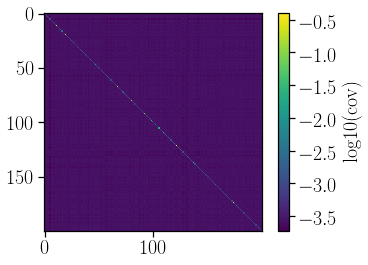

In [10]:
c = plt.imshow(np.log10(Sigmaij))
plt.colorbar(c, label='log10(cov)')
plt.show()
# rho01 = Sigmaij[0, 1] / (df.parallax_error[0] * df.parallax_error[1])
# print(rho01)

### Alright, we have a covariance matrix!

Time to include it in our model! A multivariate normal distribution, given a matrix of covariances, reads as

$p(\hat\varpi | \varpi_{true}, \sigma_{\hat\varpi}) = \frac{1}{\sqrt{(2\pi)^N |\Sigma|}} \times \exp\left[-\frac{1}{2}(\underline{\varpi_{true}} - \underline{\hat\varpi})^{\rm T} \Sigma^{-1} (\underline{\varpi_{true}} - \underline{\hat\varpi})\right]$

where $\Sigma$ is our covariance matrix, $N$ is the number of data points, and $\varpi_{true}$ is the inferred true parallax, i.e. one over the inferred distance ($1/\underline{r}$)! The underline indicates that its a vector containing all instances $i$ of the parallax.

An acyclic diagram for this new model can be seen below. The only change is that instead of $\sigma_{\hat{\varpi}_i}$ we now feed in the covariacne matrix $\Sigma_{\hat{\varpi}}$ and evaluate all the parallaxes in the vector $\underline{\hat{\varpi}}$!

![Acyclic diagram for our model](blogmodel2.png)

Lets recreate the model but now taking into account the covariance matrix.

In [11]:
import pystan
overwrite=False
yescov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    vector[N] oo;
    cov_matrix[N] Sigma;
    real L[N];
}
parameters {
    real<lower = 1.> ri[N];                            //Can't have something being closer than 1 parsec!
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);
        oo_true[n] = (1000./ri[n] - 0.029);            //We're accounting for a parallax offset of 0.029 mu-as
    }
    
    oo ~ multi_normal(oo_true, Sigma);                 //This has changed to a multi_normal now!
}
'''
import os
import pickle
model_path = 'yescov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = yescov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = yescov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [12]:
dat = {'N': len(df),
        'oo' : df.parallax.values,       #Observed parallax
        'Sigma': Sigmaij,                #The covariance matrix
        'L': df.r_length_prior.values}   #Length Scale

In [13]:
cov_fit = sm.sampling(data=dat, iter=1000, chains=2)

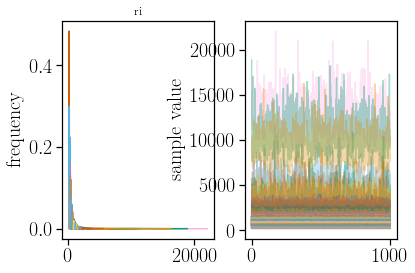

In [14]:
cov_fit.plot()
plt.show()
# print(fit)

Lets see how our distances have changed compared to our estimate without the covariance.

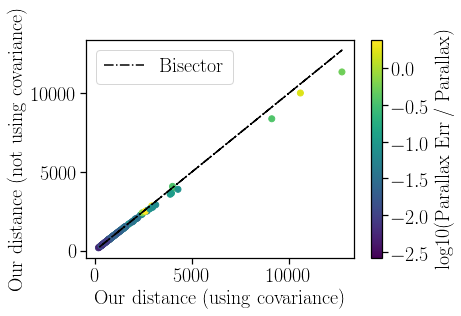

In [15]:
rinfd_cov = np.median(cov_fit['ri'], axis=0)

fig, ax = plt.subplots()
c = ax.scatter(rinfd_cov, rinfd_nocov, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis')
ax.plot(rinfd_cov, rinfd_cov, linestyle='-.', c='k', label='Bisector')
ax.legend(fontsize=20)
fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('Our distance (using covariance)')
ax.set_ylabel('Our distance (not using covariance)')
plt.show()

So this shows that by including the covariance, we find that at large distances we have previously underestimated the distance to objects with the smallest parallaxes. 

As an aside, we can see the Bailer-Jones prior at work here--- the stars closest to the bisector at large distances are those with large parallax uncertainties. For these stars the prior dominates, and thus we achieve similar results, as the effect of the covariance matters little compared to the effect of the prior.

## Caveats and closing comments

- The relation in Lindegren et al. 2018 could be inaccurate for the regions we're looking at--- they're based on quasars after all, and multiple works have found that the parallax offset from quasars does not hold up for all stars in all fields (Zinn et al. 2018, Hall et al. in prep., Riess et al. 2018).

- This is a very quick look, take it with as much salt as you like.

Hope somebody found this helpful! You can contact me on [Twitter](https://www.twitter.com/asteronomer), by [email](mailto:ojhall94@gmail.com) or on my [Github](https://www.github.com/ojhall94)!

# But wait, theres more!
When running on 200 stars without covariance the run took ~ 3s. When running on 200 stars *with* covariance, it took ~25s! It easy to see how this could inflate the time required to run large data sets to astronomical quantities. In fact, I did the math; my sample of 5500 stars for Hall et al. (in prep.) would take 27 *days* to run! So is there a way of speeding this process up?

In [33]:
import pystan
overwrite=True
fastcov = '''
functions {
    real bailerjones_lpdf(real r, real L){             //This is our distance prior
        return log((1/(2*L^3)) * (r*r) * exp(-r/L));
    }
}
data {
    int<lower = 0> N;
    vector[N] oo;
    cov_matrix[N] Sigma;
    real L[N];
}
transformed data {
    matrix[N,N] L_sigma;
    L_sigma = cholesky_decompose(Sigma);
}
parameters {
    real<lower = 1.> ri[N];                            //Can't have something being closer than 1 parsec!
}
model {
    vector[N] oo_true;

    for (n in 1:N){
        ri[n] ~ bailerjones(L[n]);
        oo_true[n] = (1000./ri[n] - 0.029);            //We're accounting for a parallax offset of 0.029 mu-as
    }
    
    oo ~ multi_normal_cholesky(oo_true, L_sigma);                 //This has changed to a multi_normal now!
}
'''
import os
import pickle
model_path = 'fastcov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = fastcov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = fastcov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f7a90303ca8d3b5d7dd89ab013fec86 NOW.


In [34]:
dat = {'N': len(df),
        'oo' : df.parallax.values,       #Observed parallax
        'Sigma':Sigmaij,                #The covariance matrix
        'L': df.r_length_prior.values}   #Length Scale

fastcov_fit = sm.sampling(data=dat, iter=1000, chains=2)

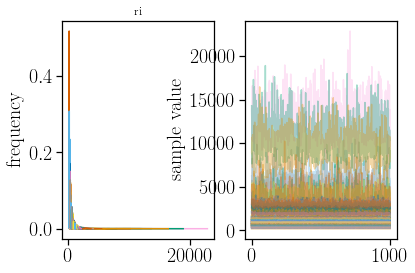

In [35]:
fastcov_fit.plot()
plt.show()
# print(fit)

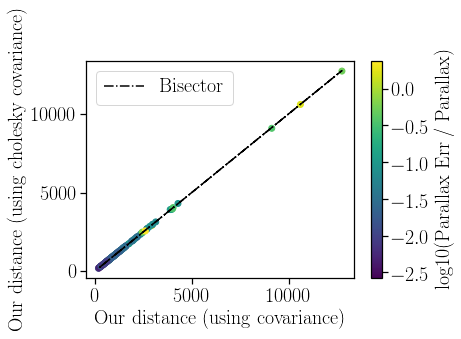

In [36]:
rinfd_fastcov = np.median(fastcov_fit['ri'], axis=0)

fig, ax = plt.subplots()
c = ax.scatter(rinfd_cov, rinfd_fastcov, c=np.log10(np.abs(1./df.parallax_over_error)), cmap='viridis')
ax.plot(rinfd_cov, rinfd_cov, linestyle='-.', c='k', label='Bisector')
ax.legend(fontsize=20)
fig.colorbar(c, label='log10(Parallax Err / Parallax)')
ax.set_xlabel('Our distance (using covariance)')
# ax.set_xlabel('Bailer-Jones distance')
ax.set_ylabel('Our distance (using cholesky covariance)')
plt.show()

# Some additional code

The code to generate the acyclic diagram using daft for the two models

In [ ]:
import daft
pgm = daft.PGM(shape=[4., 2.],origin=[0, 0], grid_unit=4,label_params={'fontsize':20},observed_style='shaded')
pgm.add_node(daft.Node("ooi", r"$\hat{\varpi}_i$", 1.5, 1, scale=2, observed=True))
pgm.add_node(daft.Node("ri", r"$r_i$", 2.5, 1, scale=2))
pgm.add_node(daft.Node("Li", r"$L_i$", 3.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("sigooi", r"$\sigma_{\hat{\varpi}_i}$", 0.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_plate(daft.Plate([0.1, 0.5, 3.8, 1.0], r"$i=0,...,N$",position='bottom right', rect_params={'fill':False}))
# draw directed edges
pgm.add_edge("ri", "ooi")
pgm.add_edge("Li", "ri")
pgm.add_edge('sigooi', 'ooi')

pgm.render()
pgm.figure.savefig('blogmodel.png')

In [ ]:
import daft
pgm = daft.PGM(shape=[4., 2.],origin=[0, 0], grid_unit=4,label_params={'fontsize':20},observed_style='shaded')
pgm.add_node(daft.Node("ooi", r"$\underline{\hat{\varpi}}$", 1.5, 1, scale=2, observed=True))
pgm.add_node(daft.Node("ri", r"$r_i$", 2.5, 1, scale=2))
pgm.add_node(daft.Node("Li", r"$L_i$", 3.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("sigooi", r"$\Sigma_{\hat{\varpi}}$", 0.5, 1, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_plate(daft.Plate([2.0, 0.5, 1.8, 1.0], r"$i=0,...,\rm N$",position='bottom right', rect_params={'fill':False}))
# draw directed edges
pgm.add_edge("ri", "ooi")
pgm.add_edge("Li", "ri")
pgm.add_edge('sigooi', 'ooi')

pgm.render()
pgm.figure.savefig('blogmodel2.png')